In [1]:
from Bio import Entrez
import xml.etree.ElementTree as ET
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/dan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#  1) Data Access tier, 2) Text Pre-Processing tier, and 3) Machine Learning tier

# 1 Data Access tier

In [3]:
def getIdList(term):
  #Get ID list
  #http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec162
  Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
  handle = Entrez.esearch(db="pubmed", term=term, datetype="pdat", mindate="2010", retmax="1000000")#yyyy/mm/dd #max retmax
  record = Entrez.read(handle)
  handle.close()
  idlist = record["IdList"]

  return idlist

In [4]:
terms = ["knee osteoarthritis", "abnormalities, cardiovascular", "acute rheumatic arthritis", "disease, lyme"]

In [5]:
allDocs = list()
for term in terms:
  print(term)

#load/download xml files for each term
  try:
    #try to load the file with elementtree
    tree = ET.parse(term + ".xml")
  except FileNotFoundError:
    #files arent here download them
    ids = getIdList(term)
    print(len(ids))
    print(type(ids))
    #download xml files from pubmed
    with Entrez.efetch(db="pubmed", id=ids, retmode="xml") as handle:
      with open(term + ".xml", 'wb') as file:
        file.write(handle.read())
    tree = ET.parse(term + ".xml")
  # create empty list for all documents

  #create a list of pairs with abstracts and class
  root = tree.getroot()
  abstract = list()
  #some abstracts have multiple tags and are split, need to combine
  for match in root.findall(".//PubmedArticle"):
    abstract = []
    for abst in match.findall(".//AbstractText"):
        abstract.append(abst.text)
    ab = "".join(abst for abst in abstract if abst is not None)
    allDocs.append((ab, term))

knee osteoarthritis
abnormalities, cardiovascular
acute rheumatic arthritis
disease, lyme


# 2) Text Pre-Processing tier

In [6]:
#from HW 2  - tokenize, lemmatize, stem, remove stopwords
def normalize(text):
    #remove punctuation
    punc = RegexpTokenizer(r'\w+')
    rmvPunc = punc.tokenize(text)
    #remove stop words
    stop_words = set(stopwords.words('english'))
    removeStop = [w for w in rmvPunc if not w.lower() in stop_words]
    #lowercase
    lowerCase = [x.lower() for x in removeStop]
    #stem
    ps =PorterStemmer()
    rootWord = [ps.stem(x) for x in lowerCase]
    #lem
    wl = WordNetLemmatizer()
    lemWords = [wl.lemmatize(x) for x in rootWord]

    return lemWords

In [7]:
# format all the documents into a list
allDocsNorm = [(normalize(doc), label) for doc, label in allDocs if doc != ""]
#concatenate the first element of each pair to one string
allDocsNorm = [(' '.join(doc), label) for doc, label in allDocsNorm]


# 3) Machine Learning tier

In [17]:
# get alldocsNorm ready for sklearn
X = [doc for doc, label in allDocsNorm]
y = [label for doc, label in allDocsNorm]

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)



Accuracy: 0.941326
Precision: 0.941
Recall: 0.941
F1: 0.941


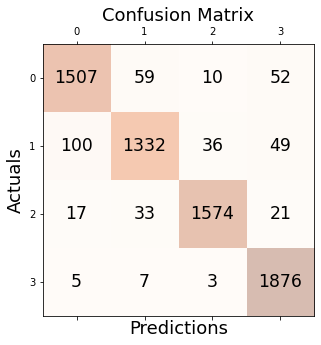

In [18]:
# naive bayes
pipe  = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

print('Accuracy: %3f' % accuracy_score(y_test, predicted))
print('Precision: %.3f' % precision_score(y_test, predicted, average='micro'))
print('Recall: %.3f' % recall_score(y_test, predicted, average='micro'))
print('F1: %.3f' % f1_score(y_test, predicted, average='micro'))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.31)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Accuracy: 0.972310
Precision: 0.972
Recall: 0.972
F1: 0.972


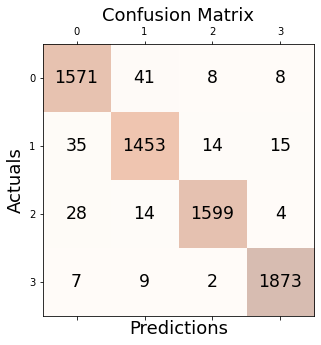

In [14]:
#svm

pipe = Pipeline([
    ('vect', TfidfVectorizer(max_df=0.9)),
    ('clf', SGDClassifier(loss='hinge', penalty='l1',
                          alpha=1e-5, random_state=42,
                          max_iter=10, tol=None)),
])

pipe.fit(X_train, y_train) #Train model
# 
predicted = pipe.predict(X_test) #Run model

#Evaluate model
print('Accuracy: %3f' % accuracy_score(y_test, predicted))
print('Precision: %.3f' % precision_score(y_test, predicted, average='micro'))
print('Recall: %.3f' % recall_score(y_test, predicted, average='micro'))
print('F1: %.3f' % f1_score(y_test, predicted, average='micro'))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.31)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

/home/dan/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.951654
Precision: 0.952
Recall: 0.952
F1: 0.952


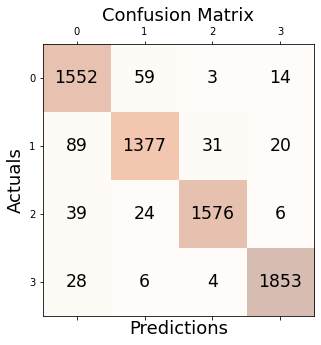

In [28]:
#logistic regression

pipe = Pipeline([   #Pipeline for logistic regression
    ('vect', TfidfVectorizer(max_df=0.8,)),
    ('clf', LogisticRegression(penalty='l2', C=3, random_state=42,
                                 max_iter=10)),
])

pipe.fit(X_train, y_train) #Train model

predicted = pipe.predict(X_test)

#Evaluate model
print('Accuracy: %3f' % accuracy_score(y_test, predicted))
print('Precision: %.3f' % precision_score(y_test, predicted, average='micro'))
print('Recall: %.3f' % recall_score(y_test, predicted, average='micro'))
print('F1: %.3f' % f1_score(y_test, predicted, average='micro'))




conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicted)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.31)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()